In [1]:
import os
os.chdir('drive/My Drive/MLProject_20202')

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from utils import get_lstm_vectors, get_doc2vec_vectors, plot_loss,\
                    plot_cm, plot_metrics, plot_prc, plot_roc

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
df_cat = pd.read_csv('Data/data_all_categorical.csv', encoding='utf-8')
y = df_cat.fraudulent

df_cat_no_target = df_cat.loc[:, df_cat.columns != 'fraudulent']
categorical_vectors = df_cat_no_target.to_numpy()

In [5]:
df_text = pd.read_csv("Data/data_text_clean.csv", encoding='utf-8')
text_all = df_text['clean_text'].tolist()

In [401]:
MODEL_TYPE = 'dbow'
MODEL_OUTPUT = 100

In [402]:
doc2vec_model = Doc2Vec.load(f"Model/Doc2Vec/doc2vec_pv_{MODEL_TYPE}_{MODEL_OUTPUT}.model")

In [403]:
context_vectors = get_doc2vec_vectors(doc2vec_model, MODEL_OUTPUT, text_all)

In [404]:
X = np.concatenate((context_vectors ,categorical_vectors), axis = 1)

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [406]:
# initial bias
pos = sum(y==1)
neg = sum(y==0)

initial_bias = np.log([pos/neg])
initial_bias

array([-2.9779069])

In [407]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = pos + neg
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 10.32


In [408]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(X_train, metrics=METRICS, output_bias=None, hidden_size=64):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          hidden_size, activation='relu',
          input_shape=(X_train.shape[-1],)),
    #   keras.layers.Dropout(0.2),
      keras.layers.Dense(
          128, activation='relu'),
    #   keras.layers.Dropout(0.2),
      keras.layers.Dense(
          64, activation='relu'),
    #   keras.layers.Dropout(0.2),
    #   keras.layers.Dense(
    #       32, activation='relu'),
    #   keras.layers.Dropout(0.2),
    #   keras.layers.Dense(
    #       32, activation='relu'),
    #   keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [409]:
EPOCHS = 400
BATCH_SIZE = 512
HIDDEN_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [410]:
weighted_model = make_model(X_train, output_bias=initial_bias, hidden_size=HIDDEN_SIZE)
weighted_model.layers[-1].bias.assign([0.0])
weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/400
23/23 [==============================] - 4s 62ms/step - loss: 0.6722 - tp: 135.1250 - fp: 2035.2500 - tn: 4021.0417 - fn: 159.5000 - accuracy: 0.6383 - precision: 0.0570 - recall: 0.4423 - auc: 0.5676 - prc: 0.0644 - val_loss: 0.7089 - val_tp: 139.0000 - val_fp: 1321.0000 - val_tn: 1379.0000 - val_fn: 22.0000 - val_accuracy: 0.5306 - val_precision: 0.0952 - val_recall: 0.8634 - val_auc: 0.8100 - val_prc: 0.2701
Epoch 2/400
23/23 [==============================] - 0s 14ms/step - loss: 0.5796 - tp: 205.8750 - fp: 1463.3750 - tn: 4588.3750 - fn: 93.2917 - accuracy: 0.7193 - precision: 0.1131 - recall: 0.6938 - auc: 0.7669 - prc: 0.2113 - val_loss: 0.4331 - val_tp: 113.0000 - val_fp: 459.0000 - val_tn: 2241.0000 - val_fn: 48.0000 - val_accuracy: 0.8228 - val_precision: 0.1976 - val_recall: 0.7019 - val_auc: 0.8353 - val_prc: 0.3309
Epoch 3/400
23/23 [==============================] - 0s 13ms/step - loss: 0.4941 - tp: 212.7917 - fp: 1153.9583 - tn: 4897.1667 - fn: 87.0000 - accu

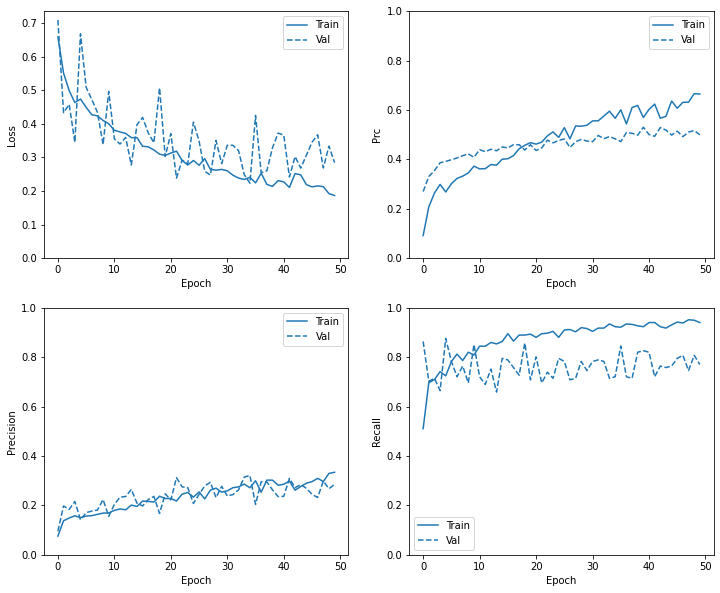

In [411]:
plot_metrics(weighted_history, colors)

In [412]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.3629913032054901
tp :  145.0
fp :  524.0
tn :  2880.0
fn :  27.0
accuracy :  0.8459172248840332
precision :  0.2167413979768753
recall :  0.8430232405662537
auc :  0.906837522983551
prc :  0.43244075775146484

True Job Postings Detected (True Negatives):  2880
True Job Postings Incorrectly Detected (False Positives):  524
False Job Postings Missed (False Negatives):  27
False Job Postings Detected (True Positives):  145
Total False Job Postings:  172


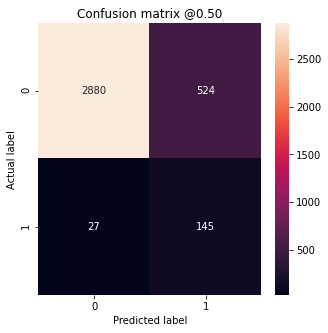

In [413]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

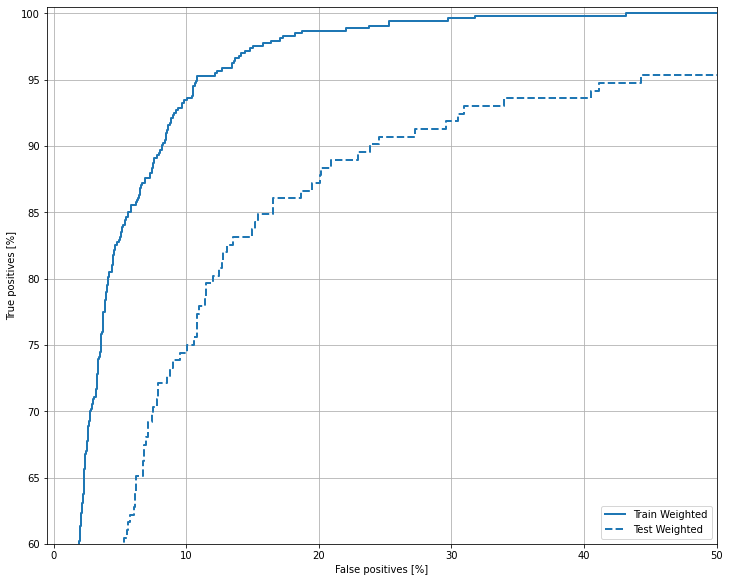

In [414]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[0])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

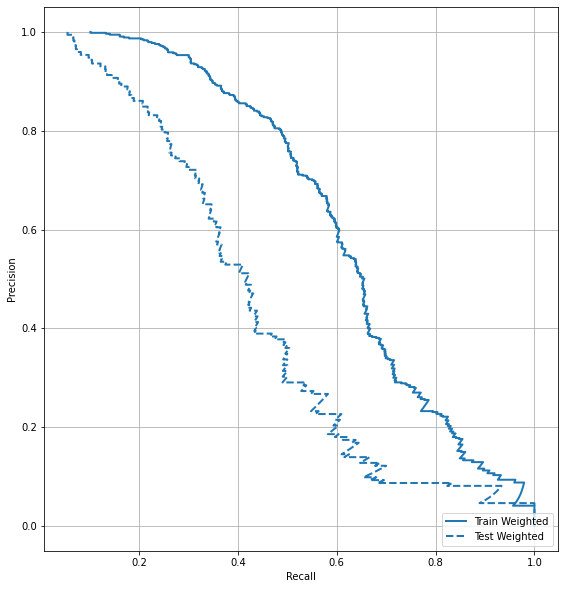

In [415]:
plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[0])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [416]:
weighted_model.save(f'Model/Doc2Vec/Classification/NN_{MODEL_TYPE}')

INFO:tensorflow:Assets written to: Model/Doc2Vec/Classification/NN_dbow/assets
